In [1]:
import numpy as np
from matplotlib import pyplot as plt

import skimage
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle, vortex
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

from skimage.filters import threshold_otsu

In [2]:
import os
import cv2
from PIL import Image
import pandas as pd
from tqdm import tqdm

In [3]:
DATA_PATH = '/Users/nastya/Documents/ucu/thesis/data/drive_data'

In [4]:
test_data = pd.read_csv('/Users/nastya/Documents/ucu/thesis/voxelmorph/drive_new/vm_gan_drive_new/test_split.csv')

In [5]:
pairs = []

for index, row in test_data.iterrows():
    target_image = row['targets'].replace('/content/drive_data', DATA_PATH)
    source_image = row['sources'].replace('/content/drive_data', DATA_PATH)
    pairs.append((target_image, source_image))

In [6]:
def dice_score(image1, image2, threshold=True):
    # Convert images to grayscale
    if len(image1.shape) > 2:
        image1 = rgb2gray(image1)
    if len(image2.shape) > 2:
        image2 = rgb2gray(image2)

    # Thresholding (if required)
    if threshold:
        threshold_value1 = threshold_otsu(image1)
        threshold_value2 = threshold_otsu(image2)
        image1 = (image1 > threshold_value1).astype(np.uint8)
        image2 = (image2 > threshold_value2).astype(np.uint8)

    # Calculate Dice score
    intersection = np.sum(image1 & image2)
    union = np.sum(image1) + np.sum(image2)
    dice = (2.0 * intersection) / union
    return dice

In [7]:
def mean_squared_error(image1, image2):
    assert image1.shape == image2.shape, "Images must have the same dimensions"

    mse = np.mean((image1 - image2)**2)
    return mse

In [8]:
targets = []
sources = []

dice_scores = []
mse_scores = []

In [9]:
registered_images = []

In [10]:
def load_image(image_path, resize=None):
    pil_image = Image.open(image_path)
    numpy_array = np.array(pil_image)
    if resize:
        numpy_array = cv2.resize(numpy_array, resize)
    return numpy_array

In [11]:
import time

start_time = time.time()

for pair in tqdm(pairs):

    targets.append(pair[0])
    sources.append(pair[1])
    
    target_image = load_image(pair[0], (256, 256))
    source_image = load_image(pair[1], (256, 256))

    target_image = (target_image > 127).view(np.uint8) * 255
    source_image = (source_image > 127).view(np.uint8) * 255

    # target_image = rgb2gray(target_image)
    # source_image = rgb2gray(source_image)

    v, u = optical_flow_tvl1(target_image, source_image, num_iter=100)

    nr, nc = target_image.shape
    row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
    source_image_warp = warp(source_image, np.array([row_coords + v, col_coords + u]), mode='edge')

    source_image_warp_float = source_image_warp.astype(np.float64) / 255.0
    target_image_float = target_image.astype(np.float64) / 255.0

    registered_images.append(source_image_warp)

    dice = dice_score(source_image_warp_float, target_image_float)
    mse = mean_squared_error(source_image_warp_float, target_image_float)

    dice_scores.append(dice)
    mse_scores.append(mse)

end_time = time.time() - start_time

print(f'Inference time: {end_time}')

100%|██████████| 80/80 [09:06<00:00,  6.83s/it]

Inference time: 546.7919261455536


In [12]:
metrics_data = pd.DataFrame({
    'target': targets,
    'source': sources,
    'dice': dice_scores,
    'mse': mse_scores
})

In [13]:
metrics_data.to_csv('/Users/nastya/Documents/ucu/thesis/optical_flow/drive/results_v2/metrics_masks.csv', index=False)

In [14]:
metrics_data['mse'].mean()

0.08392332693356405

In [15]:
metrics_data['dice'].mean()

0.8717742094886403

In [18]:
import pickle

with open('/Users/nastya/Documents/ucu/thesis/optical_flow/drive/results_v2/registered.pkl', 'wb') as f:
    pickle.dump(registered_images, f)

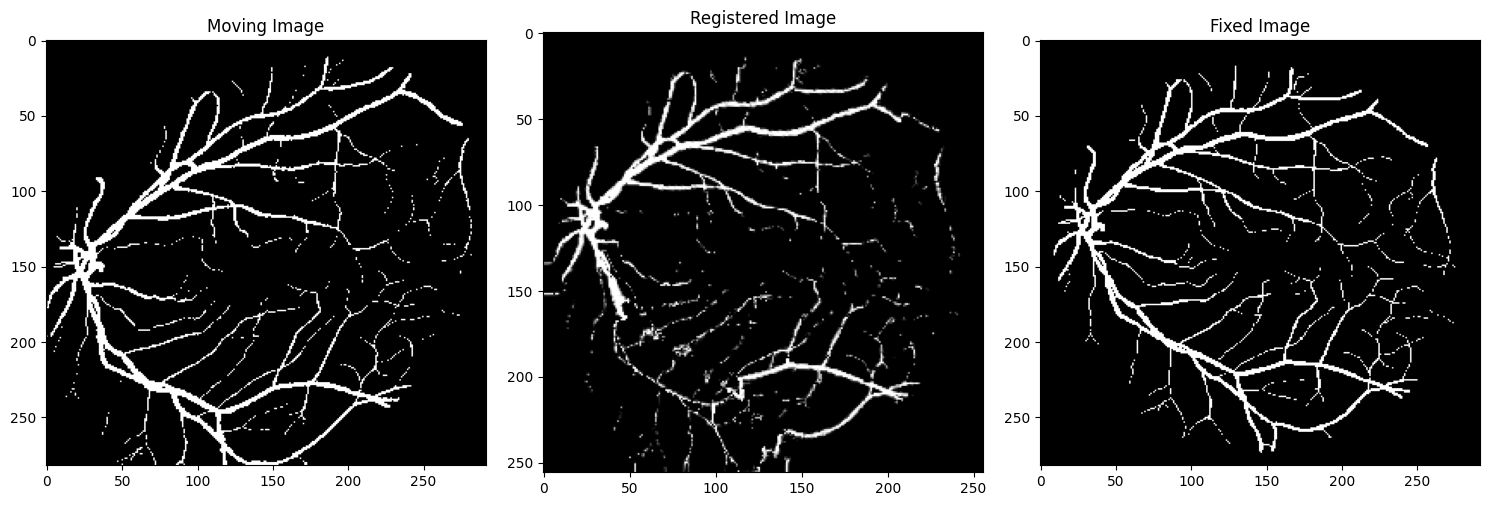

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow((load_image(sources[0]) > 127).view(np.uint8) * 255, cmap='gray')
axes[0].set_title('Moving Image')

axes[1].imshow(registered_images[0], cmap='gray')
axes[1].set_title('Registered Image')

axes[2].imshow((load_image(targets[0]) > 127).view(np.uint8) * 255, cmap='gray')
axes[2].set_title('Fixed Image')

plt.tight_layout()
plt.show()

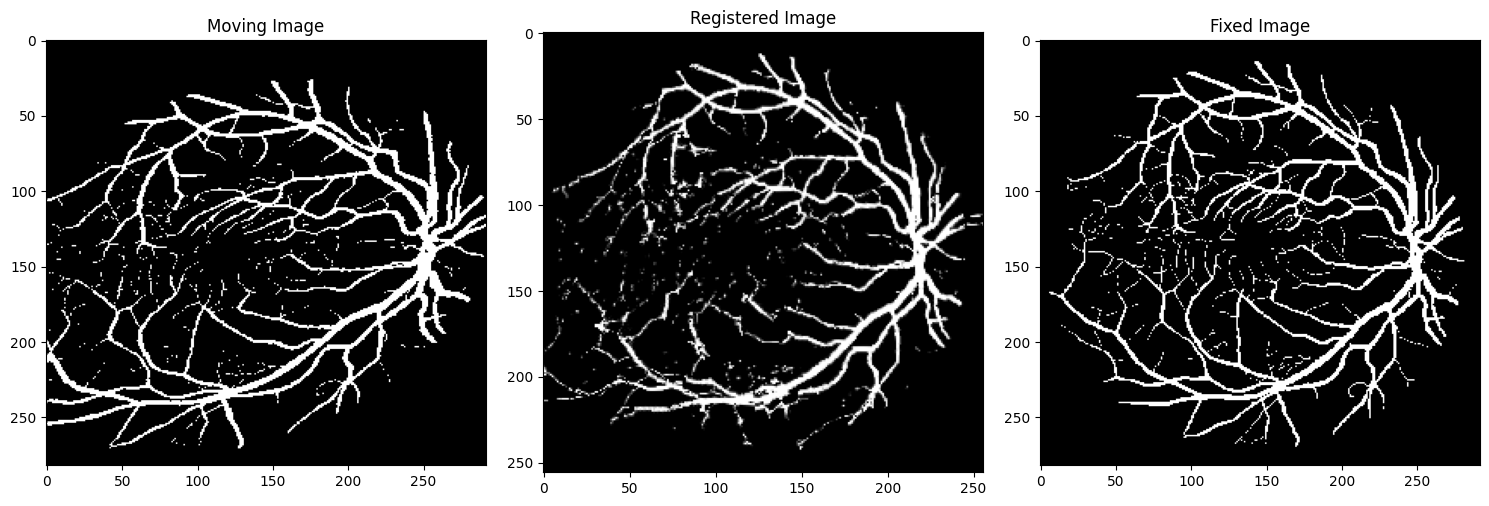

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow((load_image(sources[11]) > 127).view(np.uint8) * 255, cmap='gray')
axes[0].set_title('Moving Image')

axes[1].imshow(registered_images[11], cmap='gray')
axes[1].set_title('Registered Image')

axes[2].imshow((load_image(targets[11]) > 127).view(np.uint8) * 255, cmap='gray')
axes[2].set_title('Fixed Image')

plt.tight_layout()
plt.show()

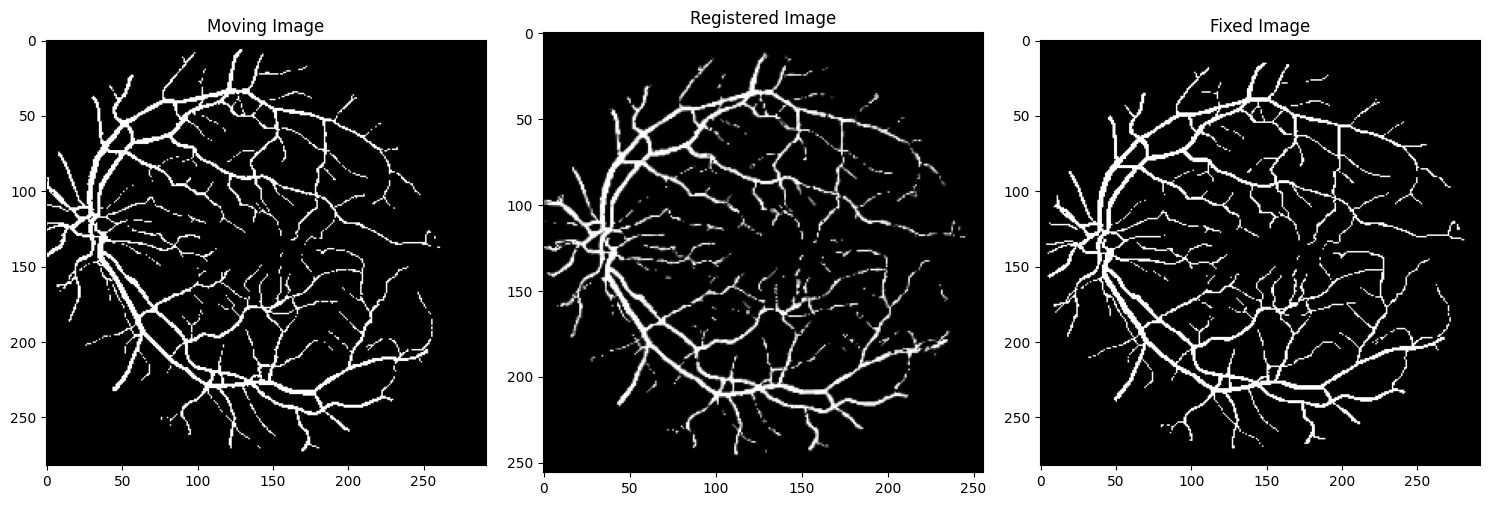

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow((load_image(sources[32]) > 127).view(np.uint8) * 255, cmap='gray')
axes[0].set_title('Moving Image')

axes[1].imshow(registered_images[32], cmap='gray')
axes[1].set_title('Registered Image')

axes[2].imshow((load_image(targets[32]) > 127).view(np.uint8) * 255, cmap='gray')
axes[2].set_title('Fixed Image')

plt.tight_layout()
plt.show()

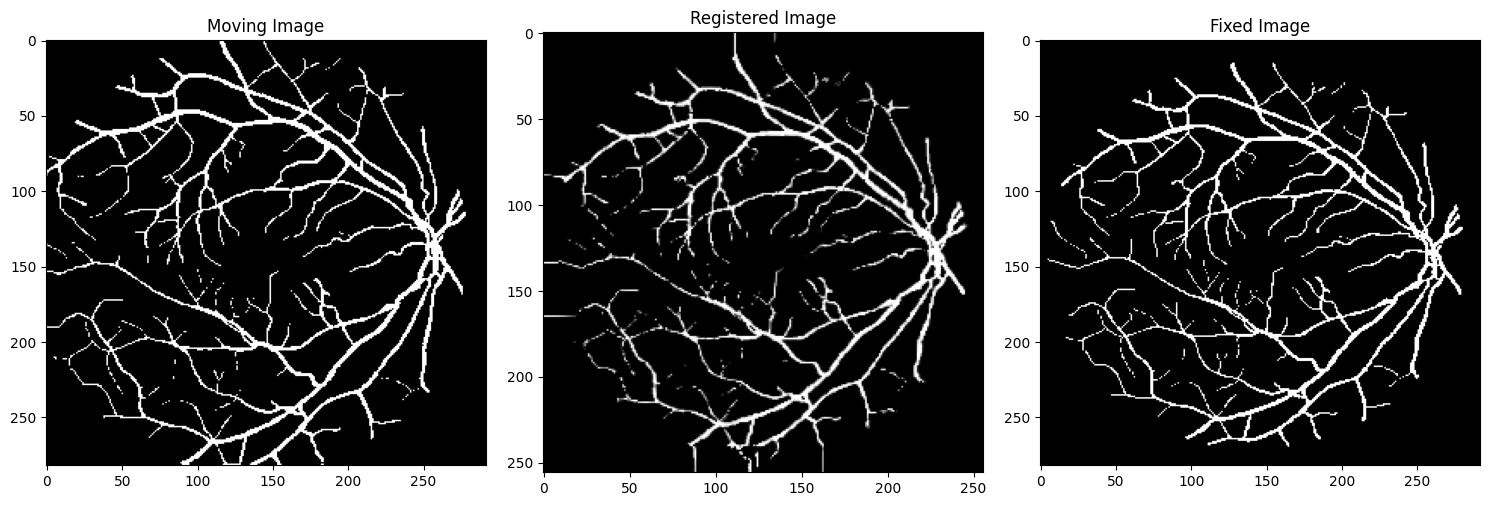

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow((load_image(sources[31]) > 127).view(np.uint8) * 255, cmap='gray')
axes[0].set_title('Moving Image')

axes[1].imshow(registered_images[31], cmap='gray')
axes[1].set_title('Registered Image')

axes[2].imshow((load_image(targets[31]) > 127).view(np.uint8) * 255, cmap='gray')
axes[2].set_title('Fixed Image')

plt.tight_layout()
plt.show()

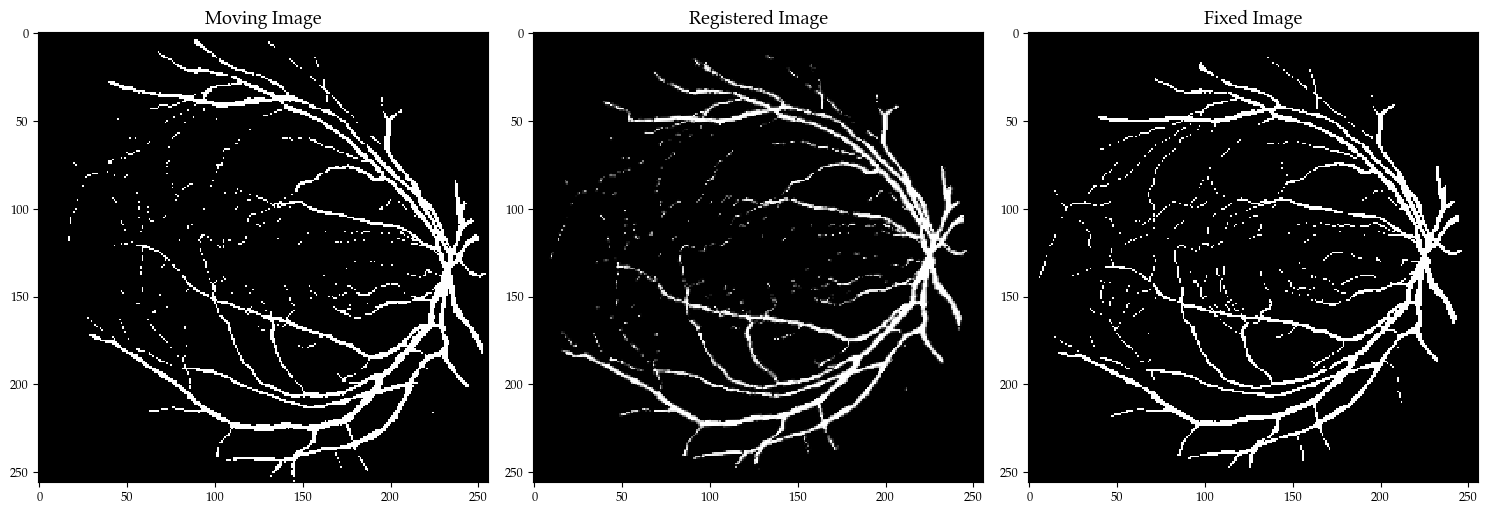

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered_images[78] ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow((cv2.resize(load_image(targets[78]), (256, 256)) > 127).view(np.uint8) * 255 ,cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow((cv2.resize(load_image(sources[78]), (256, 256)) > 127).view(np.uint8) * 255 ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()

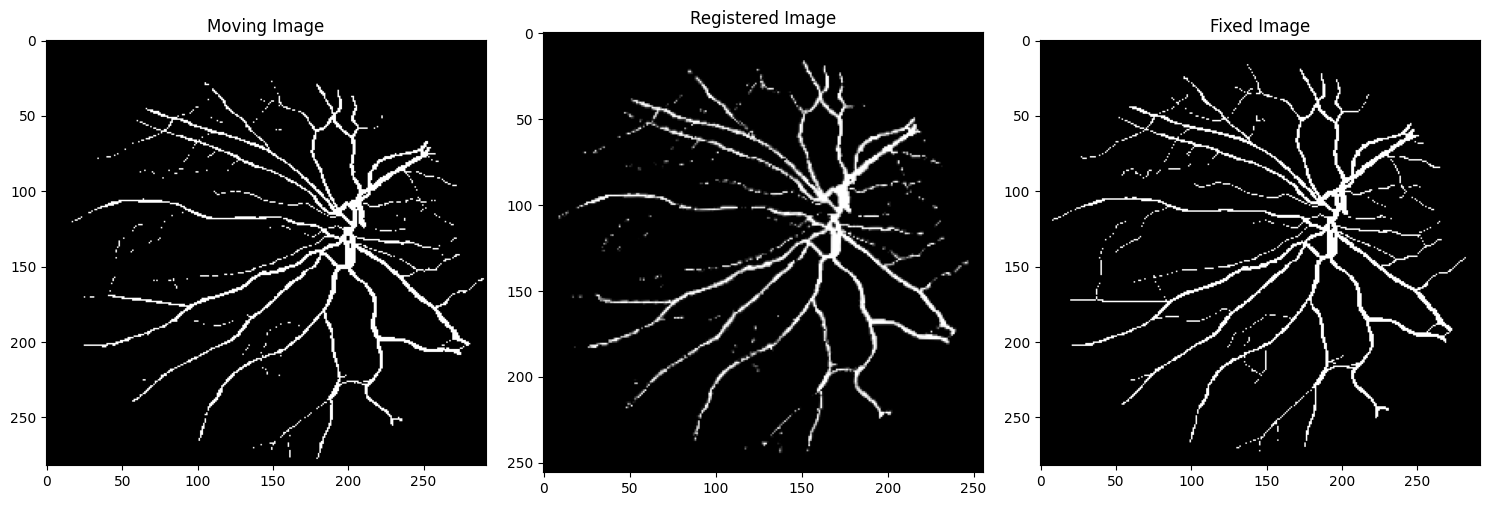

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow((load_image(sources[22]) > 127).view(np.uint8) * 255, cmap='gray')
axes[0].set_title('Moving Image')

axes[1].imshow(registered_images[22], cmap='gray')
axes[1].set_title('Registered Image')

axes[2].imshow((load_image(targets[22]) > 127).view(np.uint8) * 255, cmap='gray')
axes[2].set_title('Fixed Image')

plt.tight_layout()
plt.show()

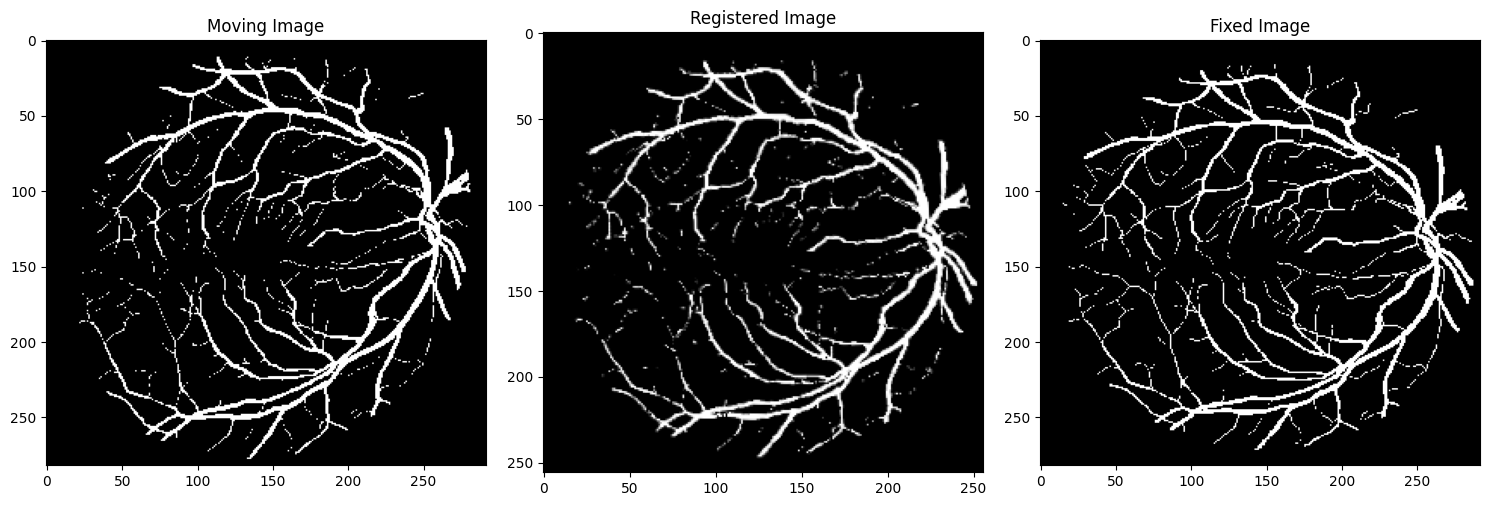

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow((load_image(sources[13]) > 127).view(np.uint8) * 255, cmap='gray')
axes[0].set_title('Moving Image')

axes[1].imshow(registered_images[13], cmap='gray')
axes[1].set_title('Registered Image')

axes[2].imshow((load_image(targets[13]) > 127).view(np.uint8) * 255, cmap='gray')
axes[2].set_title('Fixed Image')

plt.tight_layout()
plt.show()